In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import glob
import os

plt.style.use('ggplot') # Make the graphs a bit prettier

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("~/results/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
frames['program_run'][frames['algorithm_run'].groupby('program_run_id').size() < 42]['graph']


470fe0c6-04df-41d0-8e25-b3870debcec8    ../../../data/uk-2002.metis.graph
6d57ebf9-04c1-414b-874c-8d4395065410    ../../../data/uk-2002.metis.graph
a9d1f0e9-0594-44b0-9ad8-e33fc19fc203    ../../../data/uk-2002.metis.graph
b067797e-5170-475c-a334-6c616ef84fba    ../../../data/uk-2002.metis.graph
b89c9c40-8726-4289-80e8-4aede2eed85e    ../../../data/uk-2002.metis.graph
Name: graph, dtype: object

In [6]:
frames['program_run'].graph.unique()

array(['../../../data/in-2004.metis.graph',
       '../../../data/lfr-100000-mu-0.2.metis.graph',
       '../../../data/lfr-1000000-mu-0.2.metis.graph',
       '../../../data/com-lj.ungraph.txt',
       '../../../data/com-dblp.ungraph.txt',
       '../../../data/com-amazon.ungraph.txt',
       '../../../data/uk-2002.metis.graph'], dtype=object)

In [44]:
graphs = frames['program_run'].loc[lambda x: x.graph.str.contains("uk-")]
algos = frames['algorithm_run'].merge(graphs, left_on='program_run_id', right_index=True)

In [45]:
graphs[:1]

,edge_count,seed,commit,ground_proof,timestamp,binary,node_count,graph
470fe0c6-04df-41d0-8e25-b3870debcec8,261787258,1608692783,a544039be741562f348dc61b72c244dc5d993f83,NaN,2017-02-05 04:52:57 +0100,./louvain,18520486,../../../data/uk-2002.metis.graph


In [46]:
frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.algorithm.str.contains("sequential")] \
    ['cluster_count'] \
    .mean()

770438.3

In [47]:
frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .merge(frames['partition'], left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .groupby(['algorithm_y', 'size', 'allow_move_to_ghosts'])['cluster_count'].mean()

algorithm_y                                            size  allow_move_to_ghosts
chunk                                                  4     False                     903136
                                                             True                      959903
                                                       32    False                     943356
                                                             True                     1028411
                                                       128   False                     957280
                                                             True                     1043740
                                                       1024  False                    1032488
                                                             True                     1103007
cluster_based                                          4     False                     772772
                                                             True       

In [51]:
frames['partition_element'] \
    .merge(frames['partition'], left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    .groupby(['size', 'algorithm_x'])['cut_weight'].mean()

size  algorithm_x                                          
4     chunk                                                      9404346
      cluster_based                                              1345450
      deterministic_greedy_with_linear_penalty                  53224875
      random                                                   196342187
      random_order_deterministic_greedy_with_linear_penalty     60830055
32    chunk                                                     12299093
      cluster_based                                              2562776
      deterministic_greedy_with_linear_penalty                  71831734
      random                                                   253605352
      random_order_deterministic_greedy_with_linear_penalty     80081889
128   chunk                                                     13066271
      cluster_based                                              4382022
      deterministic_greedy_with_linear_penalty                  

In [52]:
frames['partition_element'] \
    .merge(frames['partition'], left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    .groupby(['size', 'algorithm_x'])['ghost_count'].mean()

size  algorithm_x                                          
4     chunk                                                    1.073760e+06
      cluster_based                                            2.363990e+05
      deterministic_greedy_with_linear_penalty                 2.882059e+06
      random                                                   1.097560e+07
      random_order_deterministic_greedy_with_linear_penalty    3.681154e+06
32    chunk                                                    2.263837e+05
      cluster_based                                            6.696456e+04
      deterministic_greedy_with_linear_penalty                 7.712063e+05
      random                                                   6.301600e+06
      random_order_deterministic_greedy_with_linear_penalty    9.607671e+05
128   chunk                                                    6.421030e+04
      cluster_based                                            2.452314e+04
      deterministic_greedy_w

In [50]:
frames['partition_element'] \
    .groupby('partition_id', as_index=False)['ghost_count'].sum() \
    .merge(frames['partition'], left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    .groupby(['size', 'algorithm_x'])['ghost_count'].mean()

IndentationError: unexpected indent (<ipython-input-50-5e379875a83d>, line 2)

(array([ 883.,    3.,    1.,    0.,    2.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([  1.00000000e+00,   2.08800000e+01,   4.07600000e+01,
          6.06400000e+01,   8.05200000e+01,   1.00400000e+02,
          1.20280000e+02,   1.40160000e+02,   1.60040000e+02,
          1.79920000e+02

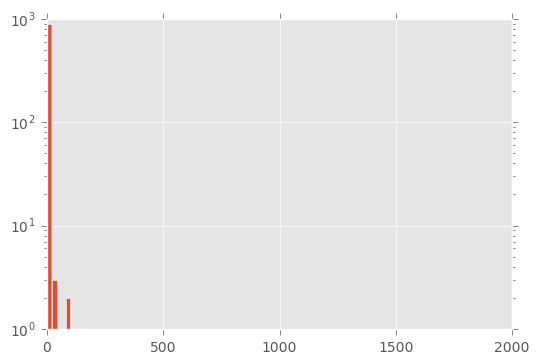

In [42]:
connected_component_sizes = frames['partition_element'] \
    .merge(frames['partition'], left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    [['size', 'algorithm_x', 'connected_components']].iloc[0]['connected_components']
    
plt.hist(pd.Series(connected_component_sizes), log=True, bins=100) 

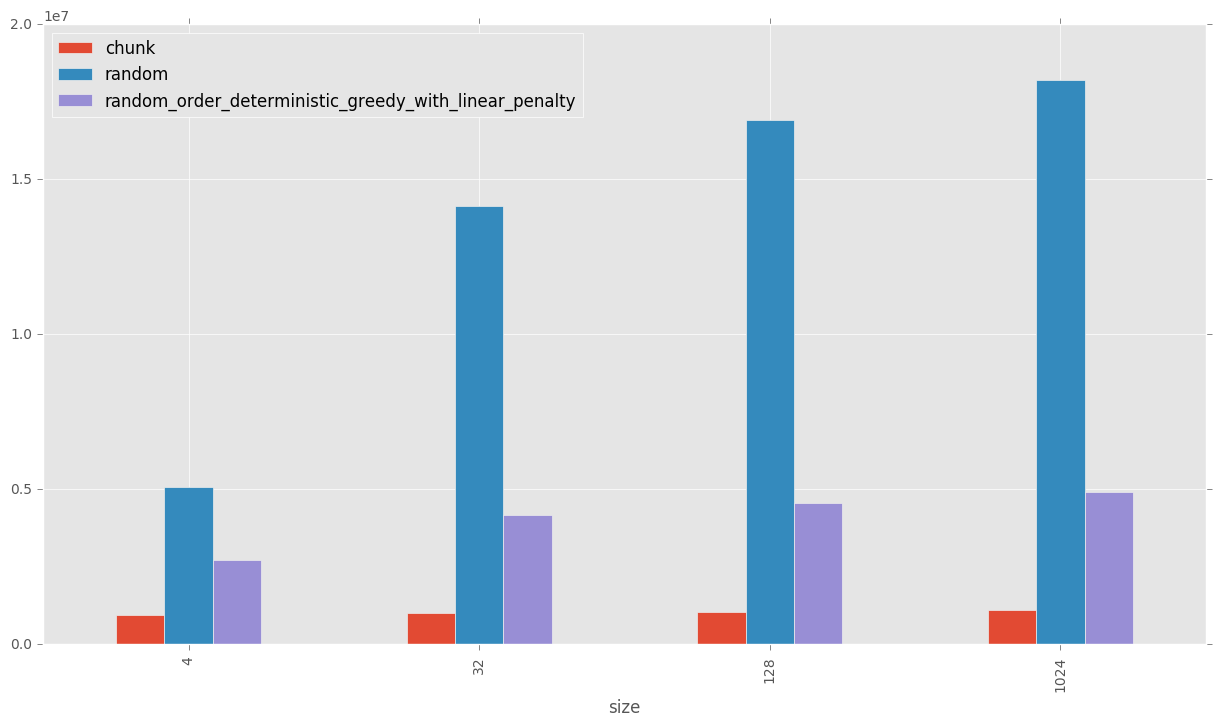

In [80]:
groups = frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .merge(frames['partition'], left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .loc[lambda x: x.allow_move_to_ghosts] \
    .loc[lambda x: ~x.algorithm_y.isin(["deterministic_greedy_with_linear_penalty", "cluster_based"])] \
    .groupby(['algorithm_y'], as_index=False)


pd.DataFrame({algo: levels.groupby('size')['cluster_count'].mean() for algo, levels in groups}).plot.bar(figsize=(15,8))